In [135]:
#!pip install -q pgmpy

# Noisy-OR model

## Deterministic OR

It is easy to see that an OR between many variables can factorize as a product of tables involving only three variables

$$
\begin{align}\label{eq:or}
 \text{OR}(y|x_1,x_2,x_3) & = \sum_{s\in\{0,1\}} \text{OR}(y|3,s)\text{OR}(s|x_1,x_2).
\end{align}
$$


## Noisy OR

The noisy-OR model \[1\] represents a joint probability distribution composed of an effect variable $y$ that has $K$ parents $x_k, k=1,...,K$. For simplicity, we will assume that all of them are binary. It factorizes as

$$
\begin{align}
 P(y=0|x_1,...,x_K) & = P(y=0|L)\prod_{k=1}^{K} P(y=0|x_k)\\
 & = (1-\lambda_0)\prod_{k=1}^{K} (1-\lambda_k)^{x_k},
\end{align}
$$

where $\lambda_k$ is used to parameterize the probability that the parent $k$, if present, could alone determine the effect to have a positive outcome. The parameter $\lambda_0 = P(y=1|L)$, also known as leak probability, is the probability that $y$ occurs by means other than the specified parents.

Note that since $x_k$ appears in the exponent, when the parent is not active ($x_k=0$), the corresponding term is one, so the probability is not affected by $\lambda_k$. On the contrary, when $x_k=1$, the lower the value of $\lambda_k$, the less likely will be that the effect is present, and vice-versa.


## Using exponentially large OR tables

A simple way to represent this model consists of $K$ factors (one for each parent $x_k$) that have a direct relation with a hidden variable $z_k$. These potentials encode the local probability that the effect is active or not, given the value of the cause only:

<table>
    <tr><th>$x_k$</th><th>$z_k$</th><th>$P(z_k|x_k)$</th></tr>
    <tr><td> 0 </td> <td> 0 </td> <td> $1$ </td></tr>
    <tr><td> 0 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 0 </td> <td> $(1-\lambda_k)$ </td></tr>
    <tr><td> 1 </td> <td> 1 </td> <td> $\lambda_k$ </td></tr>
</table>

An additional leak factor $L$ is also introduced to account for the term $(1-\lambda_0)$ and $L$ is usually set to $1$ (i.e. $P(L=1)=1$).

All these factors are combined using a deterministic OR factor. The size of this gate grows exponentially in $K$. For example, for $K=3$:

<table>
    <tr><th> $z_0$ </th> <th> $z_1$ </th> <th> $z_2$ </th> <th> $z_3$ </th> <th> $P(y=0|z_0,z_1,z_2,z_3)$ </th></tr>
    <tr><td> 0 </td> <td> 0 </td> <td> 0 </td> <td> 0 </td> <td> $1$ </td></tr>
    <tr><td> 0 </td> <td> 0 </td> <td> 0 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 0 </td> <td> 1 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 0 </td> <td> 1 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 1 </td> <td> 0 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 1 </td> <td> 0 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 1 </td> <td> 1 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 0 </td> <td> 1 </td> <td> 1 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 0 </td> <td> 0 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 0 </td> <td> 0 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 0 </td> <td> 1 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 0 </td> <td> 1 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 1 </td> <td> 0 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 1 </td> <td> 0 </td> <td> 1 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 1 </td> <td> 1 </td> <td> 0 </td> <td> $0$ </td></tr>
    <tr><td> 1 </td> <td> 1 </td> <td> 1 </td> <td> 1 </td> <td> $0$ </td></tr>
</table>
<br><center>Table 1: A deterministic OR factor: full table for four inputs</center>

Note that we also need to specify the prior probabilities for $x_k, \forall k$. For simplicity, we will assume they are uniform.


Create a model like that and experiment with different values of $\boldsymbol{\lambda}$. For example, assume $\lambda_0=10^{-3},\lambda_1=0.9,\lambda_2=0.5,\lambda_3=0.99$. The corresponding graphical model is <br> <img src="https://raw.githubusercontent.com/guillermoim/resources/main/noisyor.png" width=350 height=230>

Construct this model using python.


In [136]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import DiscreteFactor, TabularCPD
import numpy as np
import itertools


def to_cpd(phi, x):
    """
    Returns a TabularCPD object from a DiscreteFactor. For a given factor phi(x_0, ..., x_n)
    and a variable x_i, it interprets the factor as a CPD P(x_i|Y), where Y is the set of all
    variables in phi except x_i. I.e. P(x_i|x_0, ..., x_{i-1}, x_{i+1}, ..., x_n).
    It also checks that the factor is a valid conditional probability distribution.
    """
    assert x in phi.variables
    idx = phi.variables.index(x)
    card = list(phi.cardinality)
    var_card = card[idx]
    evidence_card = card[:idx] + card[idx + 1 :]
    values = np.moveaxis(phi.values, idx, 0)  # move variable x to dimension 0
    return TabularCPD(
        variable=x,
        variable_card=var_card,
        evidence=phi.variables[:idx] + phi.variables[idx + 1 :],
        evidence_card=evidence_card,
        values=values.reshape(
            var_card, int(np.prod(evidence_card))
        ),  # int cast since np.prod([])=1.0
        state_names=phi.state_names,
    )

In [137]:
vars = ["L", "x1", "x2", "x3", "z0", "z1", "z2", "z3", "Y"]
domains = {i: [0, 1] for i in vars}
lambdas = [10e-3, 0.9, 0.5, 0.99, 0.0]  # Add an extra element to lambdas list
p = dict()

p["L"] = DiscreteFactor(
    variables=["L"], cardinality=[2], values=[0, 1], state_names=domains
)

for i in range(1, 4):
    p["x" + str(i)] = DiscreteFactor(
        variables=["x" + str(i)],
        cardinality=[2],
        values=[0.5, 0.5],
        state_names=domains,
    )

p["z0"] = DiscreteFactor(
    variables=["L", "z0"],
    cardinality=[2, 2],
    values=[0, 1, 1 - lambdas[0], lambdas[0]],
    state_names=domains,
)

for i in range(1, 4):
    p["z" + str(i)] = DiscreteFactor(
        variables=["x" + str(i), "z" + str(i)],
        cardinality=[2, 2],
        values=[0, 1, 1 - lambdas[i], lambdas[i]],
        state_names=domains,
    )


print(p["z0"])
print(p["z1"])
print(p["z2"])
print(p["z3"])

+------+-------+-------------+
| L    | z0    |   phi(L,z0) |
+======+=======+=============+
| L(0) | z0(0) |      0.0000 |
+------+-------+-------------+
| L(0) | z0(1) |      1.0000 |
+------+-------+-------------+
| L(1) | z0(0) |      0.9900 |
+------+-------+-------------+
| L(1) | z0(1) |      0.0100 |
+------+-------+-------------+
+-------+-------+--------------+
| x1    | z1    |   phi(x1,z1) |
+=======+=======+==============+
| x1(0) | z1(0) |       0.0000 |
+-------+-------+--------------+
| x1(0) | z1(1) |       1.0000 |
+-------+-------+--------------+
| x1(1) | z1(0) |       0.1000 |
+-------+-------+--------------+
| x1(1) | z1(1) |       0.9000 |
+-------+-------+--------------+
+-------+-------+--------------+
| x2    | z2    |   phi(x2,z2) |
+=======+=======+==============+
| x2(0) | z2(0) |       0.0000 |
+-------+-------+--------------+
| x2(0) | z2(1) |       1.0000 |
+-------+-------+--------------+
| x2(1) | z2(0) |       0.5000 |
+-------+-------+--------------+

In [158]:
import numpy as np
import itertools
from pgmpy.factors.discrete import DiscreteFactor

# Define the variables, domains, and lambda values
vars = ["L", "x1", "x2", "x3", "z0", "z1", "z2", "z3", "Y"]
domains = {var: [0, 1] for var in vars}
lambdas = [
    1e-3,
    0.9,
    0.5,
    0.99,
]  # leak probability and failure probabilities for x1, x2, x3
p = dict()

# Define DiscreteFactors for L and x's
p["L"] = DiscreteFactor(
    variables=["L"],
    cardinality=[2],
    values=[1 - lambdas[0], lambdas[0]],
    state_names=domains,
)
for i, x in enumerate(["x1", "x2", "x3"], start=1):
    p[x] = DiscreteFactor(
        variables=[x], cardinality=[2], values=[0.5, 0.5], state_names=domains
    )

# Define DiscreteFactors for z's based on the Noisy-OR model
for i, z in enumerate(["z0", "z1", "z2", "z3"], start=0):
    p[z] = DiscreteFactor(
        variables=[vars[i], z],
        cardinality=[2, 2],
        values=[1, 0, 1 - lambdas[i], lambdas[i]],
        state_names=domains,
    )

In [161]:
model = BayesianNetwork([("L", "z0"), ("x1", "z1"), ("x2", "z2"), ("x3", "z3")])

cpd_L = to_cpd(p["L"], "L")
cpd_x1 = to_cpd(p["x1"], "x1")
cpd_x2 = to_cpd(p["x2"], "x2")
cpd_x3 = to_cpd(p["x3"], "x3")

cpd_L_z0 = to_cpd(p["z0"], "z0")
cpd_x1_z1 = to_cpd(p["z1"], "z1")
cpd_x2_z2 = to_cpd(p["z2"], "z2")
cpd_x3_z3 = to_cpd(p["z3"], "z3")


model.add_cpds(cpd_L_z0, cpd_L, cpd_x1, cpd_x1_z1, cpd_x2, cpd_x2_z2, cpd_x3, cpd_x3_z3)

print(model.check_model())

True


In [162]:
print("CPDs list:")
print(model.get_cpds())

print("")
print("CPD for Butler:")
print(model.get_cpds("L"))

print("")
print("CPD for Knife:")
print(model.get_cpds("Y"))

CPDs list:
[<TabularCPD representing P(z0:2 | L:2) at 0x298327d10>, <TabularCPD representing P(L:2) at 0x2981daf90>, <TabularCPD representing P(x1:2) at 0x2981da110>, <TabularCPD representing P(z1:2 | x1:2) at 0x298307890>, <TabularCPD representing P(x2:2) at 0x2983b9f10>, <TabularCPD representing P(z2:2 | x2:2) at 0x298253510>, <TabularCPD representing P(x3:2) at 0x2987d4510>, <TabularCPD representing P(z3:2 | x3:2) at 0x29824a010>]

CPD for Butler:
+------+-------+
| L(0) | 0.999 |
+------+-------+
| L(1) | 0.001 |
+------+-------+

CPD for Knife:


ValueError: Node not present in the Directed Graph

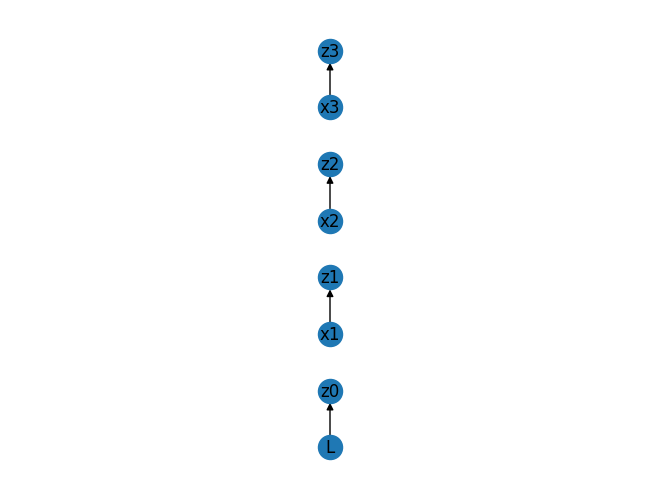

In [163]:
import networkx as nx

pos = {node: (0, index) for index, node in enumerate(model.nodes())}
nx.draw(model, pos=pos, with_labels=True)

Answer the following questions:

1. What is $P_1=P(y=1|x_1=0,x_2=0,x_3=1)$?


2. Argue why $P_2=P(y=1|x_1=0,x_2=1,x_3=0)$ is smaller than $P_1$.


3. Relate $P_3=P(y=1|x_1=0,x_2=1,x_3=1)$ with $P_2$ and $P_1$.


4. Relate $P_4=P(y=1|x_1=0,x_2=0,x_3=0)$ with all the previous probabilities.


5. What are the posterior probabilities of each individual parent, if we observe that $y=1$? How do they change if we observe that $y=0$?


## Efficient representation

The previous networks contains a factor with exponetial size, which renders it unfeasible for large $K$. Based on the factorization of the deterministic OR shown at the top, can you think of a more efficient way to represent the noisy-OR model?

Answer the following questions:

1. Using the efficient representation, compute the probabilities of the previous subsection and check they are equivalent


2. Construct a noisy-OR model with $K=6$ and $\boldsymbol{\lambda} = (10^{-4}, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5)$. Again, assume uniform priors for $x_k$ and $P(L=1)=1$.
   - For $\mathbf{x}=(0,0,0,0,0,1)$, what is the probability $p(y|\mathbf{x})$?
   - Let $\mathbf{x}=(1,0,0,0,0,1)$ What is the probability $p(y|\mathbf{x})$?


## References

\[1\] J. Pearl. Probabilistic reasoning in intelligent systems: networks of plausible inference. Elsevier, 2014.
